<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/10-attention-mechanisms/01_attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention mechanisms

Deep learning models can also learn to pay attention to some input, or features, and
ignore other features. They do this with attention mechanisms, which are another type of
prior belief we can impose on our network. 

Attention mechanisms help us deal with
situations where part of our input may be irrelevant, or when we need to focus on one
feature of many features being fed into the model.

We would like to endow our networks with the ability to ignore superfluous and
distracting inputs to focus on the most important portions, and that’s the goal of
an attention mechanism. 

If you believe some of your input features are more or less
important than other features, you should consider using an attention-based approach
in your model. 

If you want state-of-the-art results on speech recognition, object detection,
a chat bot, or machine translation, for instance, you will probably be using an attention
mechanism.

In this notebook, we see how attention works on some toy problems out of the MNIST dataset that is too hard for a normal network but is easily and better
solved with a simple kind of attention that learns how to score the importance of each
item in the input. 

Then we improve the simple attention into a full-fledged approach
that takes into account some context to better infer the importance of items in the input.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now that we can load the dataset.

In [ ]:
# let’s quickly load MNIST dataset
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Attention mechanisms are most useful when we have multiple items as inputs into our model.

Since MNIST is a single digit, we will augment each item in MNIST to become a
bag of digits. We use fully connected layers for this (i.e., flattened MNIST, ignoring the
image nature), so instead of having a batch of digits `(B,D)`, we have `T` digits `(B, T, D)`.

So why did I call this a bag instead of a sequence? 

Because we don’t care in what order
the digits are presented in the tensor. We just need a tensor large enough to hold everything in the bag.

Given a bag of digits $x_1, x_2, ... , x_T$ , we have a label y that is equal to the largest digit in the bag. If our bag contains 0, 2, 9, the label for the bag is “9.”

Let's implements a LargestDigit class to wrap an input dataset and create new items by
randomly filling a bag of toSample items and selecting the maximum label value.

In [7]:
class LargestDigit(Dataset):
  """
  Creates a modified version of a dataset where some number of samples are taken, 
  and the true label is the largest label sampled. When used with MNIST the labels 
  correspond to their values (e.g., digit "6" has label 6)
  """
  def __init__(self, dataset, toSample=3):
    """
    dataset: the dataset to sample from
    toSample: the number of items from the dataset to sample
    """
    self.dataset = dataset
    self.toSample = toSample 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # Randomly select n=self.toSample items from the dataset
    selected = np.random.randint(0, len(self.dataset), size=self.toSample)
    
    # Stack the n items of shape (B, *) shape into (B, n, *)
    x_new = torch.stack([self.dataset[i][0] for i in selected])
    # Label is the maximum label
    y_new = max([self.dataset[i][1] for i in selected])
    
    # Return (data, label) pair!
    return x_new, y_new

In [8]:
B = 128
epochs= 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_train, batch_size=B)

True Label is = 8


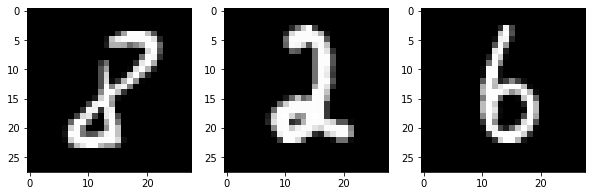

In [9]:
# Want a consistent dataset split
set_seed(34)

x, y = largest_train[0]

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
  axarr[i].imshow(x[i, 0, :].numpy(), cmap="gray", vmin=0, vmax=1)
print(f"True Label is = {y}")

##Baseline Model

Let's define some parameters.

In [ ]:
C = 1           # How many channels are in the input?
classes = 10    # How many classes are there? 
n_filters = 32  # How many filters in our backbone

In [ ]:
#Define our helper function that creates a hidden layer for a CNN
def cnn_layer(in_filters, out_filters, kernel_size=3):
  """
  in_filters: how many channels are in the input to this layer
  out_filters: how many channels should this layer output
  kernel_size: how large should the filters of this layer be
  """
  padding = kernel_size//2
  return nn.Sequential(
      nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
      nn.BatchNorm2d(out_filters),
      nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
  )

Let's build a small backbone network to use.

In [ ]:
backbone = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters, n_filters),
  cnn_layer(n_filters, n_filters),
  nn.MaxPool2d((2, 2)),

  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters),
  nn.MaxPool2d((2, 2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters, 4 * n_filters),
)

# Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters * 4

Now we can define our Faster R-CNN model. We give it the backbone network and
tell it how many classes exist and how to normalize the image.

We also tell Faster R-CNN the minimum and maximum image sizes.

In [ ]:
# How many proposals $k$ should be generated? 
# Every aspect ration will be one, and the process will be repeated for multiple image sizes 
# To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size
anchor_generator = AnchorGenerator(sizes=((32), ), aspect_ratios=((1.0), )) 

# Tell PyTorch to use the final output of the backbone as the featuremap (['0']), 
# use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

# Now we can create the FasterRCNN object. We give it the backbone network, number of classes, 
# min & max size to process images at (we know all our images at 100 pixels), 
# a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, 
                   num_classes=10,
                   image_mean=[0.5],
                   image_std=[0.229],
                   min_size=100,
                   max_size=100,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Let's implement Faster R-CNN training loop.

In [ ]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
  running_loss = 0.0
  for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
    # Move the batch to the device we are using
    inputs = moveTo(inputs, device)
    labels = moveTo(labels, device)

    optimizer.zero_grad()

    # rcnn wants model(inputs, labels) - not just model(inputs)
    losses = model(inputs, labels)

    # Compute loss, RCNN gives us a list of losses to add up.
    loss = 0
    for partial_loss in losses.values():
      loss += partial_loss
    
    # now proceed like normal
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

Now let’s see how well it did.

In [ ]:
model = model.eval()
model.to(device)

Next, let’s quickly grab an item from the test dataset and see what it looks like.

In [ ]:
set_seed(161)

x, y = test_data[0]
# the ideal truth we want to get back
print(y)

{'boxes': tensor([[31., 65., 59., 93.],
        [10., 36., 38., 64.],
        [64., 24., 92., 52.]]), 'labels': tensor([8, 0, 4])}


Let’s make a prediction.

In [ ]:
with torch.no_grad():
  pred = model([x.to(device)])

And now we can look at our results.

In [ ]:
print(pred)

[{'boxes': tensor([[63.9542, 24.0658, 92.4554, 51.6804],
        [31.7824, 65.6219, 60.5254, 93.2725],
        [31.6087, 65.1209, 60.2249, 93.4652],
        [30.4833, 65.0164, 59.1257, 93.1617],
        [70.3542, 26.2426, 95.7297, 53.9384]], device='cuda:0'), 'labels': tensor([4, 8, 9, 5, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.9656, 0.2222, 0.1316, 0.0948], device='cuda:0')}]


It’s easier to understand these results by printing them
into a picture.

In [ ]:
def plot_detection(ax, abs_pos, label=None):
  """
  ax: the matpllib axis to add this plot to
  abs_pos: the positions of the bounding box
  label: the label of the prediction to add
  """
  x1, y1, x2, y2 = abs_pos
  # make a rectangle for the bounding box
  rect_box = patches.Rectangle((x1, y1), (x2 - x1), (y2 - y1), linewidth=1, edgecolor="r", facecolor="none")
  ax.add_patch(rect_box)

  # add the label if given
  if label is not None:
    plt.text((x1 + 0.5), y1, label, color="black", bbox=dict(facecolor="white", edgecolor="white", pad=1.0))
  return

In [ ]:
def show_prediction(img, pred):
  """
  img: the image to show the bounding box predictions for
  pred: the Faster R-CNN predictions to show ontop of the image
  """
  fig,ax = plt.subplots(1)
  #plot the image
  ax.imshow(img.cpu().numpy()[0,:])
  #grab the predictions
  boxes = pred['boxes'].cpu()
  labels = pred['labels'].cpu()
  scores = pred['scores'].cpu()
  
  num_preds = labels.shape[0]
  #for each prediction, plot if if it has a high enough score
  for i in range(num_preds):
    plot_detection(ax, boxes[i].cpu().numpy(), label=str(labels[i].item()))
  
  plt.show()

Now, we can plot the result of Faster R-CNN on this image.

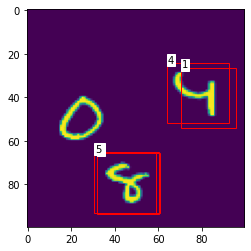

In [ ]:
show_prediction(x, pred[0])

Spurious overlapping objects are a common problem with object detectors. 

Sometimes these overlapping objects are predictions of the same object (e.g., identifying several
8s) or mislabeled predictions as we see here.

##Suppressing overlapping boxes

A simple approach called non-maximum suppression (NMS) can be used to do this.
NMS uses the intersection over union (IoU) between two boxes to determine if they overlap
too much.

Let’s quickly see how the NMS method works on our data.

In [ ]:
print(pred[0]["boxes"])

tensor([[63.9542, 24.0658, 92.4554, 51.6804],
        [31.7824, 65.6219, 60.5254, 93.2725],
        [31.6087, 65.1209, 60.2249, 93.4652],
        [30.4833, 65.0164, 59.1257, 93.1617],
        [70.3542, 26.2426, 95.7297, 53.9384]], device='cuda:0')


In [ ]:
print(pred[0]["scores"])

tensor([0.9938, 0.9656, 0.2222, 0.1316, 0.0948], device='cuda:0')


In [ ]:
print(nms(pred[0]["boxes"], pred[0]["scores"], 0.5))

tensor([0, 1], device='cuda:0')


Let’s modify our prediction function to use `NMS` to clean up the output from Faster
`R-CNN`.

In [ ]:
def show_prediction(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
  """
  img: the image to show the bounding box predictions for
  pred: the Faster R-CNN predictions to show ontop of the image
  iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
  min_score: the minimum RPN network score to consider an object
  """
  fig,ax = plt.subplots(1)
  #plot the image
  img = img.cpu().numpy()
  if img.shape[0] == 1:
    ax.imshow(img[0, :])
  else:
    ax.imshow(np.moveaxis(img, 0, 2))

  #grab the predictions
  boxes = pred['boxes'].cpu()
  labels = pred['labels'].cpu()
  scores = pred['scores'].cpu()
  
  selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
  for i in selected:
    if scores[i].item() > min_score:
      if label_names is None:
        label = str(labels[i].item())
      else:
        label = label_names[labels[i].item()]
      plot_detection(ax, boxes[i].cpu().numpy(), label=label)
  
  plt.show()

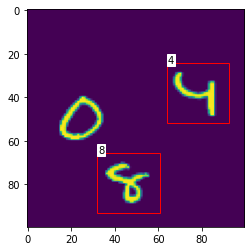

In [ ]:
show_prediction(x, pred[0])

As we see a better and cleaner result: just the 4 and 8 on their own. 

Alas, the 0 is still undetected, and
there is nothing we can do to fix that besides more data and more epochs of training.

##Pretrained Faster R-CNN

PyTorch also provides a pretrained Faster R-CNN model. It’s trained on a dataset called
COCO.

In [ ]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
# set it on eval mode since it does not need training
rcnn = rcnn.eval()

In [ ]:
# also define NAME list that contains the class names for all the objects that this pretrained R-CNN knows how to detect
NAME = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Let’s try downloading some images from the internet and see how well our model does.

In [ ]:
urls = [
    "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg",
    "https://miro.medium.com/max/5686/1*ZqJFvYiS5GmLajfUfyzFQA.jpeg",
    "https://www.denverpost.com/wp-content/uploads/2018/03/virginia_umbc_001.jpg?w=910"
]

In [ ]:
def get_prediction(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  # let's make prediction
  img = np.asarray(img) / 256.
  img = torch.tensor(img, dtype=torch.float32).permute((2, 0, 1))

  with torch.no_grad():
    # Passes the image to the model
    pred = rcnn([img])
  return img, pred

Now we can check out the results.

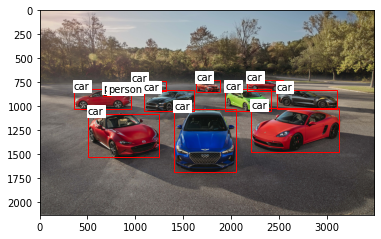

In [ ]:
img, pred = get_prediction(urls[0])

show_prediction(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)

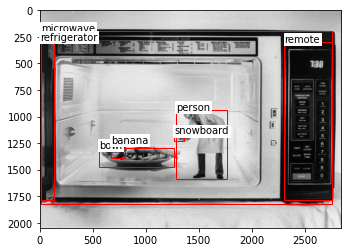

In [ ]:
img, pred = get_prediction(urls[1])

show_prediction(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)

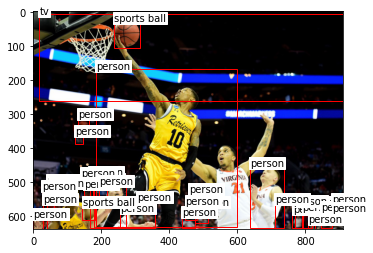

In [ ]:
img, pred = get_prediction(urls[2])

show_prediction(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)